In [1]:
%matplotlib inline
import tensorflow as tf
from vahun.corpus import Corpus
import numpy as np
from vahun.tools import Timer
from vahun.tools import explog
from vahun.autoencoder import Autoencoder_ffnn
from vahun.genetic import evolution
from vahun.genetic import experiment
from vahun.tools import show_performance

encode=180
dictsize=2000000
popsize=1


config = tf.ConfigProto()
config.gpu_options.allow_growth = True
#config.gpu_options.per_process_gpu_memory_fraction=1
corp_path='/mnt/permanent/Language/Hungarian/Corp/Webkorpusz/webkorpusz.wpl'
corp=Corpus(corpus_path=corp_path,
            needed_corpus=["hun_lower_unique"],
            language="Hun",size=dictsize,encoding_len=10)
database=corp.hun_lower_unique
all_features=corp.featurize_data_charlevel_onehot(database)
train=all_features[0:int(len(all_features)*0.8)]
test=all_features[int(len(all_features)*0.8):len(all_features)]
x_train = train.reshape((len(train), np.prod(train.shape[1:])))
x_test = test.reshape((len(test), np.prod(test.shape[1:])))
print(x_train.shape)

logger=explog(encoder_type="Demo_"+str(encode),
              encoding_dim=encode,feature_len=10,
              lang="Hun",unique_words=len(set(database)),
              name="auto_demo_uni"+str(encode),population_size=popsize,
              words=len(corp.hun_lower_unique))

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

exp=experiment(encoded_width=10,layermax=10,layermin=2,maxw=10,minw=3,out_dim=360)
#exp.weights=[348, 254, 10, 254, 348, 360]
exp.weights=[encode, 360]
exp.len=len(exp.weights)

Reading file, speed:  2262387.751843653  words/s
Reading file, speed:  2187094.0559571832  words/s
Corpus initalized, fields: ['hun_lower_unique'] 
Unique words:  214708
(81526, 360)


In [2]:
encoder=Autoencoder_ffnn(experiment=exp,
                 logger=logger,tf_session=sess,
                 inputdim=360,
                 layerlist=exp.weights,
                 encode_index=int(exp.len/2),
                 optimizer =tf.train.AdamOptimizer(learning_rate = 0.001),
                 nonlinear=tf.sigmoid)

In [3]:
encoder.train(x_train,x_test,512,80)

 barlangba 	  barlangba
 tetteiért 	  tetteiért
vonakodtam 	 bonakodtam
     héber 	      héber
    sózott 	     sózott
     haját 	      haját
 önképzési 	  önképzési
 városinál 	  városinál
gyógyított 	 béágyított
   elmúlna 	    elmulna
 prohászka 	  prohászka
   adániel 	    adániel
terepszint 	 terepszint
  emelkedő 	   emelkedő
      érve 	       érve
 hasábokat 	  hasábokat
  reményik 	   reményik
 filmeknek 	  filmeknek
 keltetőbe 	  keltetőbe
   javukra 	    favukra
   hibáját 	    hibáját
szénpernye 	 szénpernye
   épülhet 	    épülhet
     bírók 	      bírók
     kunce 	      kunge
 juttassák 	  muttassák
   emelnek 	    emelnek
 belföldön 	  belföldön
   húsáruk 	    hcsáruk
   ülepedő 	    clepedő
   űrlapon 	    örlapon
 elrendelő 	  elrendelő
 jogainkba 	  mogainkba
    törzsi 	     törzsi
  megakadt 	   megakadt
   salamon 	    salamon
 pénzekért 	  ménzekért
    hagyom 	     hagyom
folyóágyak 	 folyhágyak
    győzöm 	     gyözöm
  csinálni 	   csinálni
   eltalál 	    

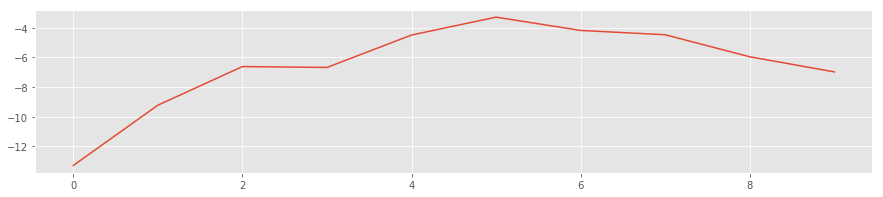

In [4]:
stds=show_performance(encoder,x_test,corp,100,printer=True)

        eh 	         er
    kecske 	     kecske
     kutya 	      kutya
     aytuk 	      aytuk
    macska 	     macska
 árvíztűrő 	  árvöztürő
      fúró 	        óró
     kacsa 	      kapsa
         a 	         ka
        és 	         és

Accuracy on data:  93.0 %


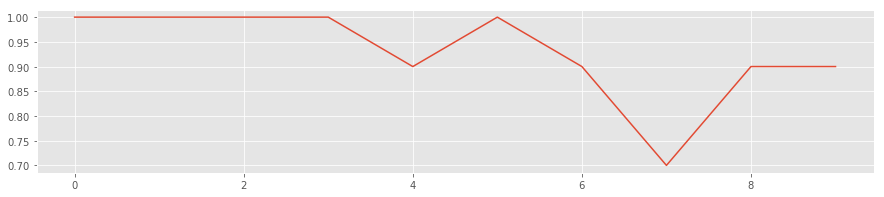

[0.11019044,
 0.10482753,
 0.095738001,
 0.10216005,
 0.069253564,
 0.078477755,
 0.1031976,
 0.07546296,
 0.081906304,
 0.10957374,
 0.060358766,
 0.075725473,
 0.055675462,
 0.082501106,
 0.072255448,
 0.073544227,
 0.095049016,
 0.055590011,
 0.078280181,
 0.11717241,
 0.071906283,
 0.075234607,
 0.072958261,
 0.051875781,
 0.092688322,
 0.06302686,
 0.10484572,
 0.083807133,
 0.10576425,
 0.093151554,
 0.10179064,
 0.052769937,
 0.067453384,
 0.099510968,
 0.084196344,
 0.081642926,
 0.10476909,
 0.080930673,
 0.092370093,
 0.044191763,
 0.077940479,
 0.11729313,
 0.071883939,
 0.04999676,
 0.080361657,
 0.048285954,
 0.079216041,
 0.045756094,
 0.077450603,
 0.1003225,
 0.092752486,
 0.070070535,
 0.061229192,
 0.068337232,
 0.10194536,
 0.071721613,
 0.05756196,
 0.070987597,
 0.076854989,
 0.050712008,
 0.10100075,
 0.066712171,
 0.079718597,
 0.10849429,
 0.10668575,
 0.098024063,
 0.021526175,
 0.094254635,
 0.066670693,
 0.11097094,
 0.061692405,
 0.081410959,
 0.11491408,
 0

In [9]:
show_performance(encoder,["eh","kecske","kutya","aytuk","macska","árvíztűrő","fúró","kacsa","a","és"],corp,printer=True)

In [6]:
def decode_critical(lista,enc=180):
    for POS in lista:
        encoded=np.ones(enc)*-10
        encoded[POS]=10
        a=encoder.decode([encoded])[0].reshape([10,36])
        b=corp.defeaturize_data_charlevel_onehot([a])
        print(b)

In [7]:
import heapq
topstd=heapq.nlargest(6, range(len(stds)), stds.__getitem__)
big_stuff=[]
for i in range(50):
    big_stuff.append([])
    for topind in topstd:
        a=encoder.encode([x_test[i]])
        a[0][topind]=2
        b=encoder.decode([a[0]])[0].reshape([10,36])
        c=corp.defeaturize_data_charlevel_onehot([b])
        big_stuff[i].append(c)
for row in big_stuff:
    print(row)

[[' barlangba'], ['  arlangba'], [' barlangba'], [' harlangba'], [' karlangba'], [' barlangba']]
[[' tetteiért'], [' t tteiért'], [' tetteiért'], [' tetteiért'], [' tetteiért'], [' tetteiért']]
[['bonakodtam'], ['  nakodtam'], ['monakodtam'], ['fonakodtam'], ['monakodtam'], [' onakodtam']]
[['     héber'], ['     hébtr'], [' ae  hébar'], ['     héber'], ['     héber'], ['     héber']]
[['    sózott'], ['    sszott'], [' ae stlott'], ['    sszott'], ['    sizott'], ['    sózott']]
[['     haját'], ['     haját'], [' ae  haját'], ['     haját'], ['     haját'], ['     haját']]
[[' önképzési'], ['  nképzése'], [' anképlési'], [' önképzési'], [' knképzési'], [' önképzési']]
[[' városinál'], ['  árosinál'], [' aárotináa'], [' városinál'], [' városinál'], [' városinál']]
[['taigyított'], ['   gyított'], ['eaegyított'], ['féégyított'], ['tklgyított'], [' fágyított']]
[['   elmllna'], ['   elmslna'], [' aeeltllaa'], ['   elmulna'], ['   elmdlna'], ['   elmilna']]
[[' erohászáa'], ['  rohászaa'